# Background



In [1]:
import bayesld
import tempfile, subprocess
import pandas as pd
import multiprocess as mp
import msprime
import numpy as np


def simulate_and_process(seed):
    """Simulate ancestry + mutations and compute LD for a given seed."""
    thetas = [1000, 10_000]
    n_samples = 20
    RECOMBINATION_RATE = 1e-8
    MUTATION_RATE = 1e-8
    CONTIG_LENGTH = 1e8

    # Simulate ancestry
    demography = msprime.Demography()
    demography.add_population(name="p0", initial_size=thetas[0])
    demography.add_population_parameters_change(
        population="p0", time=50, initial_size=thetas[1]
    )
    ts = msprime.sim_ancestry(
        samples={"p0": n_samples},
        recombination_rate=RECOMBINATION_RATE,
        sequence_length=CONTIG_LENGTH,
        random_seed=seed,
        demography=demography,
    )

    # Add mutations
    mts = msprime.sim_mutations(ts, rate=MUTATION_RATE, random_seed=seed)

    # Compute LD (inside a temporary directory)
    with tempfile.TemporaryDirectory() as tmpdir:
        trees_path = f"{tmpdir}/example.trees"
        bcf_path = f"{tmpdir}/example.bcf"

        mts.dump(trees_path)
        subprocess.run(
            f"tskit vcf --allow-position-zero {trees_path} | bcftools view -O b > {bcf_path}",
            shell=True,
            check=True,
        )
        subprocess.run(["bcftools", "index", bcf_path], check=True)

        mean, variance, n, left, right = bayesld.compute_ld(
            bcf_path, "1", RECOMBINATION_RATE
        )

    return pd.DataFrame(
        {
            "mean": mean,
            "variance": variance,
            "n": n,
            "left": left / 100,
            "right": right / 100,
            "seed": seed,
        }
    )


seeds = list(range(1, 10))  # run 10 replicates in parallel

# Parallel simulation + processing
with mp.Pool(processes=mp.cpu_count()) as pool:
    results = pool.map(simulate_and_process, seeds)

df = pd.concat(results)
data = df.pivot(index="seed", columns="left", values="mean").to_numpy()

In [2]:
import arviz as az
import numpy as np
import pytensor.tensor as pt
import bayesld.models
import pymc as pm

# Standardize data
empirical_sigma = data.std(ddof=1, axis=0)
left, right = df.left.unique(), df.right.unique()
n_contigs, n_bins = data.shape
n_samples = 20
coords = {"contig": np.arange(n_contigs), "bins": np.arange(n_bins)}

with pm.Model(coords=coords) as model:
    # Parametrize piece-wise constant
    N_1 = pm.TruncatedNormal("N_1", 5_000, 3000, lower=0)
    N_2 = pm.TruncatedNormal("N_2", 5_000, 3000, lower=0)
    t_1 = pm.TruncatedNormal("t_1", 30, 20, lower=0)

    # Expected LD
    epoch_population_sizes = [N_1, N_2]
    epoch_time_points = [t_1]
    LD = pm.Deterministic(
        "LD",
        bayesld.models.expected_ld_piecewise(
            epoch_population_sizes,
            epoch_time_points,
            left,
            right,
            sample_size=n_samples,
        ),
        dims="bins",
    )

    # Observed data: MvNormal with diagonal covariance
    obs = pm.MvNormal(
        "obs",
        mu=LD,
        cov=pt.diag(empirical_sigma**2),  # diagonal covariance
        observed=data,
        dims=("contig", "bins"),
    )

    trace = pm.sample(target_accept=0.9, draws=20_000)

az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [N_1, N_2, t_1]


Output()

/Users/currocam/Documents/Dev/bayesld/.venv/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
N_1,1015.587,28.349,961.778,1068.504,0.160,0.112,31476.0,36192.0,1.0
N_2,7054.882,2038.171,3558.811,10826.082,11.555,8.207,29143.0,33016.0,1.0
t_1,46.591,4.903,37.129,55.640,0.031,0.023,25055.0,25852.0,1.0
LD[0],0.024,0.001,0.023,0.025,0.000,0.000,73700.0,64535.0,1.0
LD[1],0.019,0.000,0.018,0.019,0.000,0.000,69436.0,61404.0,1.0
LD[2],0.016,0.000,0.015,0.016,0.000,0.000,63005.0,57165.0,1.0
LD[3],0.013,0.000,0.013,0.014,0.000,0.000,59087.0,57404.0,1.0
LD[4],0.012,0.000,0.012,0.012,0.000,0.000,51342.0,52900.0,1.0
LD[5],0.011,0.000,0.010,0.011,0.000,0.000,44365.0,47690.0,1.0
LD[6],0.010,0.000,0.009,0.010,0.000,0.000,39830.0,44617.0,1.0


array([[<Axes: title={'center': 'N_1'}>, <Axes: title={'center': 'N_1'}>],
       [<Axes: title={'center': 'N_2'}>, <Axes: title={'center': 'N_2'}>],
       [<Axes: title={'center': 't_1'}>, <Axes: title={'center': 't_1'}>]],
      dtype=object)

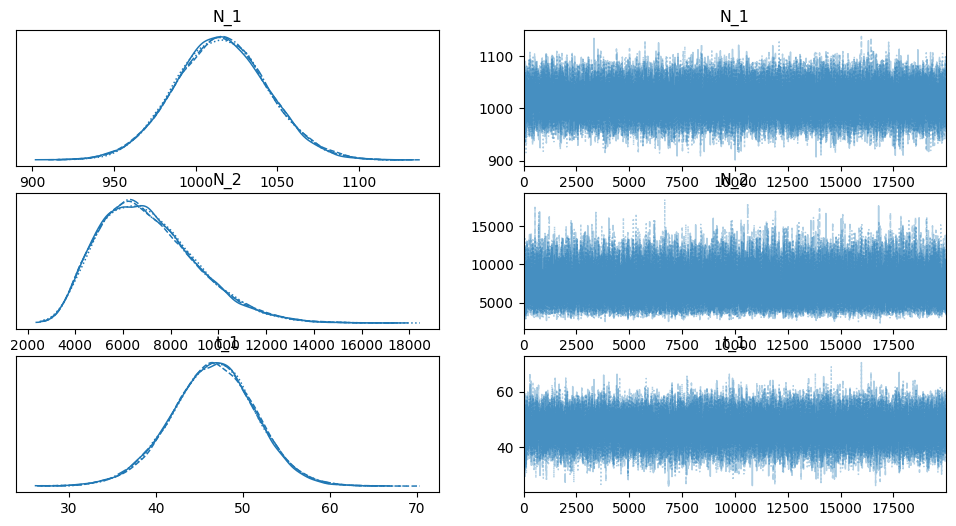

In [3]:
az.plot_trace(trace, var_names=["N_1", "N_2", "t_1"])

In [4]:
with model:
    pm.compute_log_likelihood(trace)
loo = az.loo(trace)
loo

Output()

Computed from 80000 posterior samples and 9 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   862.01    24.13
p_loo       14.68        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        9  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [5]:
with model.copy():
    LD_pp = pm.sample_posterior_predictive(trace)

Sampling: [obs]


Output()

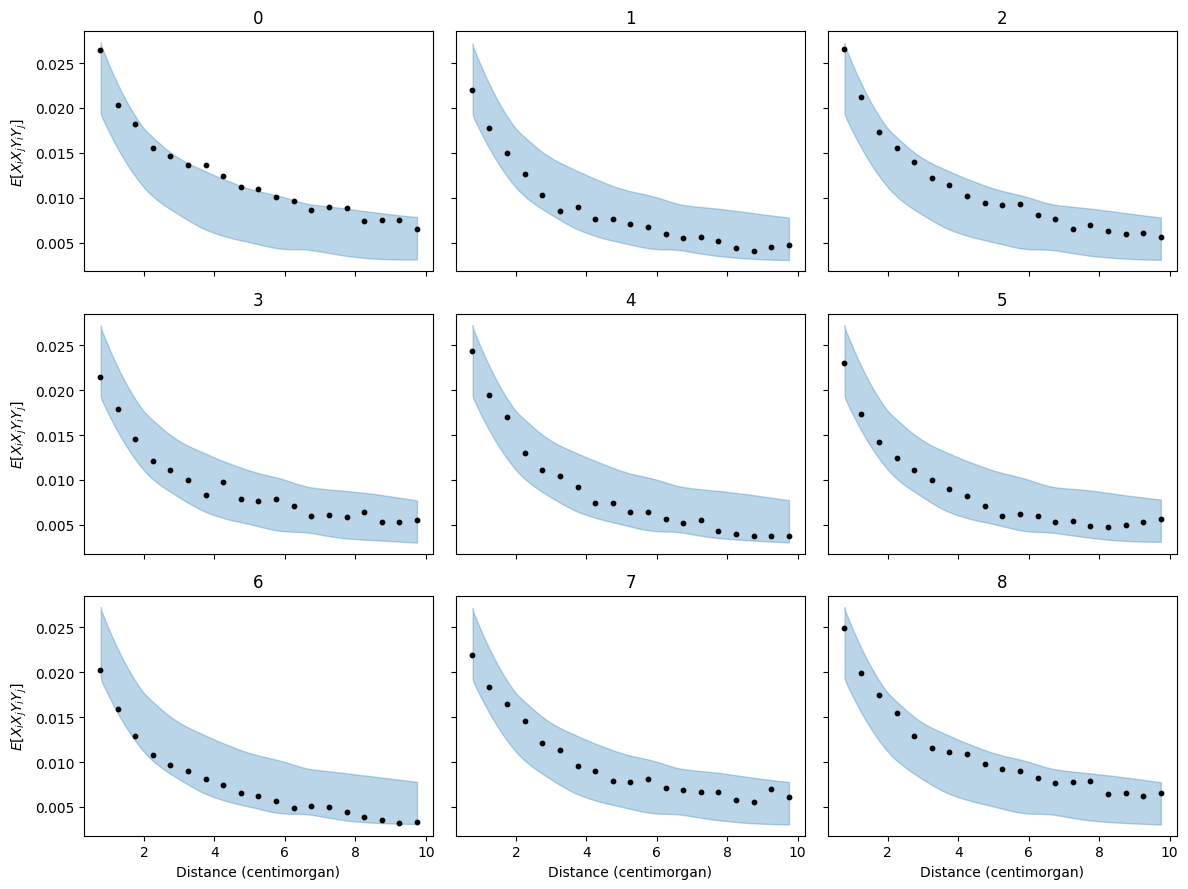

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

contigs = coords["contig"]
n_contigs = len(contigs)

# Layout: roughly square
ncols = int(np.ceil(np.sqrt(n_contigs)))
nrows = int(np.ceil(n_contigs / ncols))

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True
)
axes = axes.flatten()

x = (left + right) / 2 * 100

# HDI across chains/draws for each contig/bin
hdi_all = az.hdi(LD_pp.posterior_predictive["obs"], input_core_dims=[["chain", "draw"]])

for i, contig in enumerate(contigs):
    ax = axes[i]

    # Select contig + variable → DataArray → numpy
    hdi_c = hdi_all["obs"].sel(contig=contig).to_numpy()

    az.plot_hdi(
        x,
        hdi_data=hdi_c,
        ax=ax,
        color="C0",
        fill_kwargs={"alpha": 0.3},
    )

    # Observed data
    y_obs = LD_pp.observed_data["obs"].sel(contig=contig).to_numpy()
    ax.scatter(x, y_obs, s=10, color="black")

    ax.set_title(str(contig))
    if i % ncols == 0:
        ax.set_ylabel(r"$E[X_i X_j Y_i Y_j]$")
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel("Distance (centimorgan)")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()